In [1]:
import sys
sys.path.append('../diffusion-models-for-cosmological-fields/annotated/')

import utils
import hf_diffusion as hfd
import evaluate

/n/home02/nmudur/.conda/envs/rocky4/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
if torch.cuda.is_available():
    device='cuda'
else:
    device= 'cpu'
torch.set_default_device('cpu')
torch.set_default_dtype(torch.float32)

In [3]:
import pickle
import os
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])
import numpy as np

In [4]:
import sys
sys.path.append('../diffusion-models-for-cosmological-fields/annotated/')

In [5]:
fields_dir = '/n/holylfs05/LABS/finkbeiner_lab/Everyone/CAMELS/CMD2D/data/'

In [6]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [7]:
annotdir = '../diffusion-models-for-cosmological-fields/annotated/'

In [8]:
from matplotlib.ticker import FormatStrFormatter

In [9]:
plt.rcParams.update({'font.size': 16})

In [10]:
samppath = '../diffusion-models-for-cosmological-fields/annotated/results//checkpoint_samples/Run_10-30_2-32/0412_2239/validation/checkpoint_260000/samples.pkl'

### Summary Stats: beta monotonic and a checkpoint with Linear Pk

In [11]:
sampdict = pickle.load(open(samppath, 'rb'))
trueparams, truefields = evaluate.get_truefields_for_sampled_fields(sampdict, type='validation')

Loading true fields from /n/holylfs06/LABS/finkbeiner_lab/Users/nmudur/project_dirs/CMD_2D/data_processed/LogMaps_Mcdm_IllustrisTNG_LH_z=0.00_Nx256_val.npz. Loading params from /n/holylfs06/LABS/finkbeiner_lab/Users/nmudur/project_dirs/CMD_2D/data_processed/LogMaps_Mcdm_IllustrisTNG_LH_z=0.00_Nx256_val.npz.
Length of field file = 2250. Length of param file = 150
Parameter0: [0.3582  0.627   3.15579 0.74432 1.17202 0.6246 ] [0.3582  0.627   3.15579 0.74432 1.17202 0.6246 ] [0.3582  0.627   3.15579 0.74432 1.17202 0.6246 ] 50
[915 916 917 918 919 920 921 922 923 924 925 926 927 928 929] float32 50
Parameter50: [0.1786  0.9494  0.31425 0.53663 0.8322  1.88035] [0.1786  0.9494  0.31425 0.53663 0.8322  1.88035] [0.1786  0.9494  0.31425 0.53663 0.8322  1.88035] 50
[1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918
 1919] float32 50
Parameter100: [0.231   0.8082  0.30993 0.70613 0.69786 1.25093] [0.231   0.8082  0.30993 0.70613 0.69786 1.25093] [0.231   0.8082  0.30993 0.7

In [12]:
trueparams.shape, truefields.shape

((250, 6), (75, 256, 256))

### Power Spectra of Linear Fields

In [13]:
allfields = [10**truefields, 10**sampdict['samples'][0][:, 0]]
kvals, pklist = evaluate.get_powspec_for_samples(allfields, normalize=True)

In [14]:
import importlib
importlib.reload(evaluate)

<module 'evaluate' from '/n/holylfs06/LABS/finkbeiner_lab/Users/nmudur/project_dirs/CMD_2D/notebooks_main/../diffusion-models-for-cosmological-fields/annotated/evaluate.py'>

In [15]:
pklist[0].shape, pklist[1].shape

((75, 128), (250, 128))

In [16]:
NSTRUE, NSGEN = 15, 50

In [17]:
rng = np.random.default_rng(seed=3)
sub15 = rng.choice(NSGEN, NSTRUE, replace=False)

In [18]:
sub15

array([36, 20, 15, 47, 32, 13,  1, 25,  9,  7,  3, 29, 23,  4,  6])

In [19]:
samplists = []
names = []
for ip in range(5):
    iptrue = np.arange(ip*NSTRUE, (ip+1)*NSTRUE)
    ipgen = np.arange(ip*NSGEN, (ip+1)*NSGEN)
    param = sampdict['params'][ipgen[0]]
    pinfo = r'$\Omega_m={:.2f}$ $\sigma_8={:.2f}$'.format(param[0], param[1])
    samplists.append([pklist[0][iptrue, :], pklist[1][ipgen, :]])
    names.append(pinfo)

In [20]:
names

['$\\Omega_m=0.36$ $\\sigma_8=0.63$',
 '$\\Omega_m=0.18$ $\\sigma_8=0.95$',
 '$\\Omega_m=0.23$ $\\sigma_8=0.81$',
 '$\\Omega_m=0.41$ $\\sigma_8=0.80$',
 '$\\Omega_m=0.26$ $\\sigma_8=0.75$']

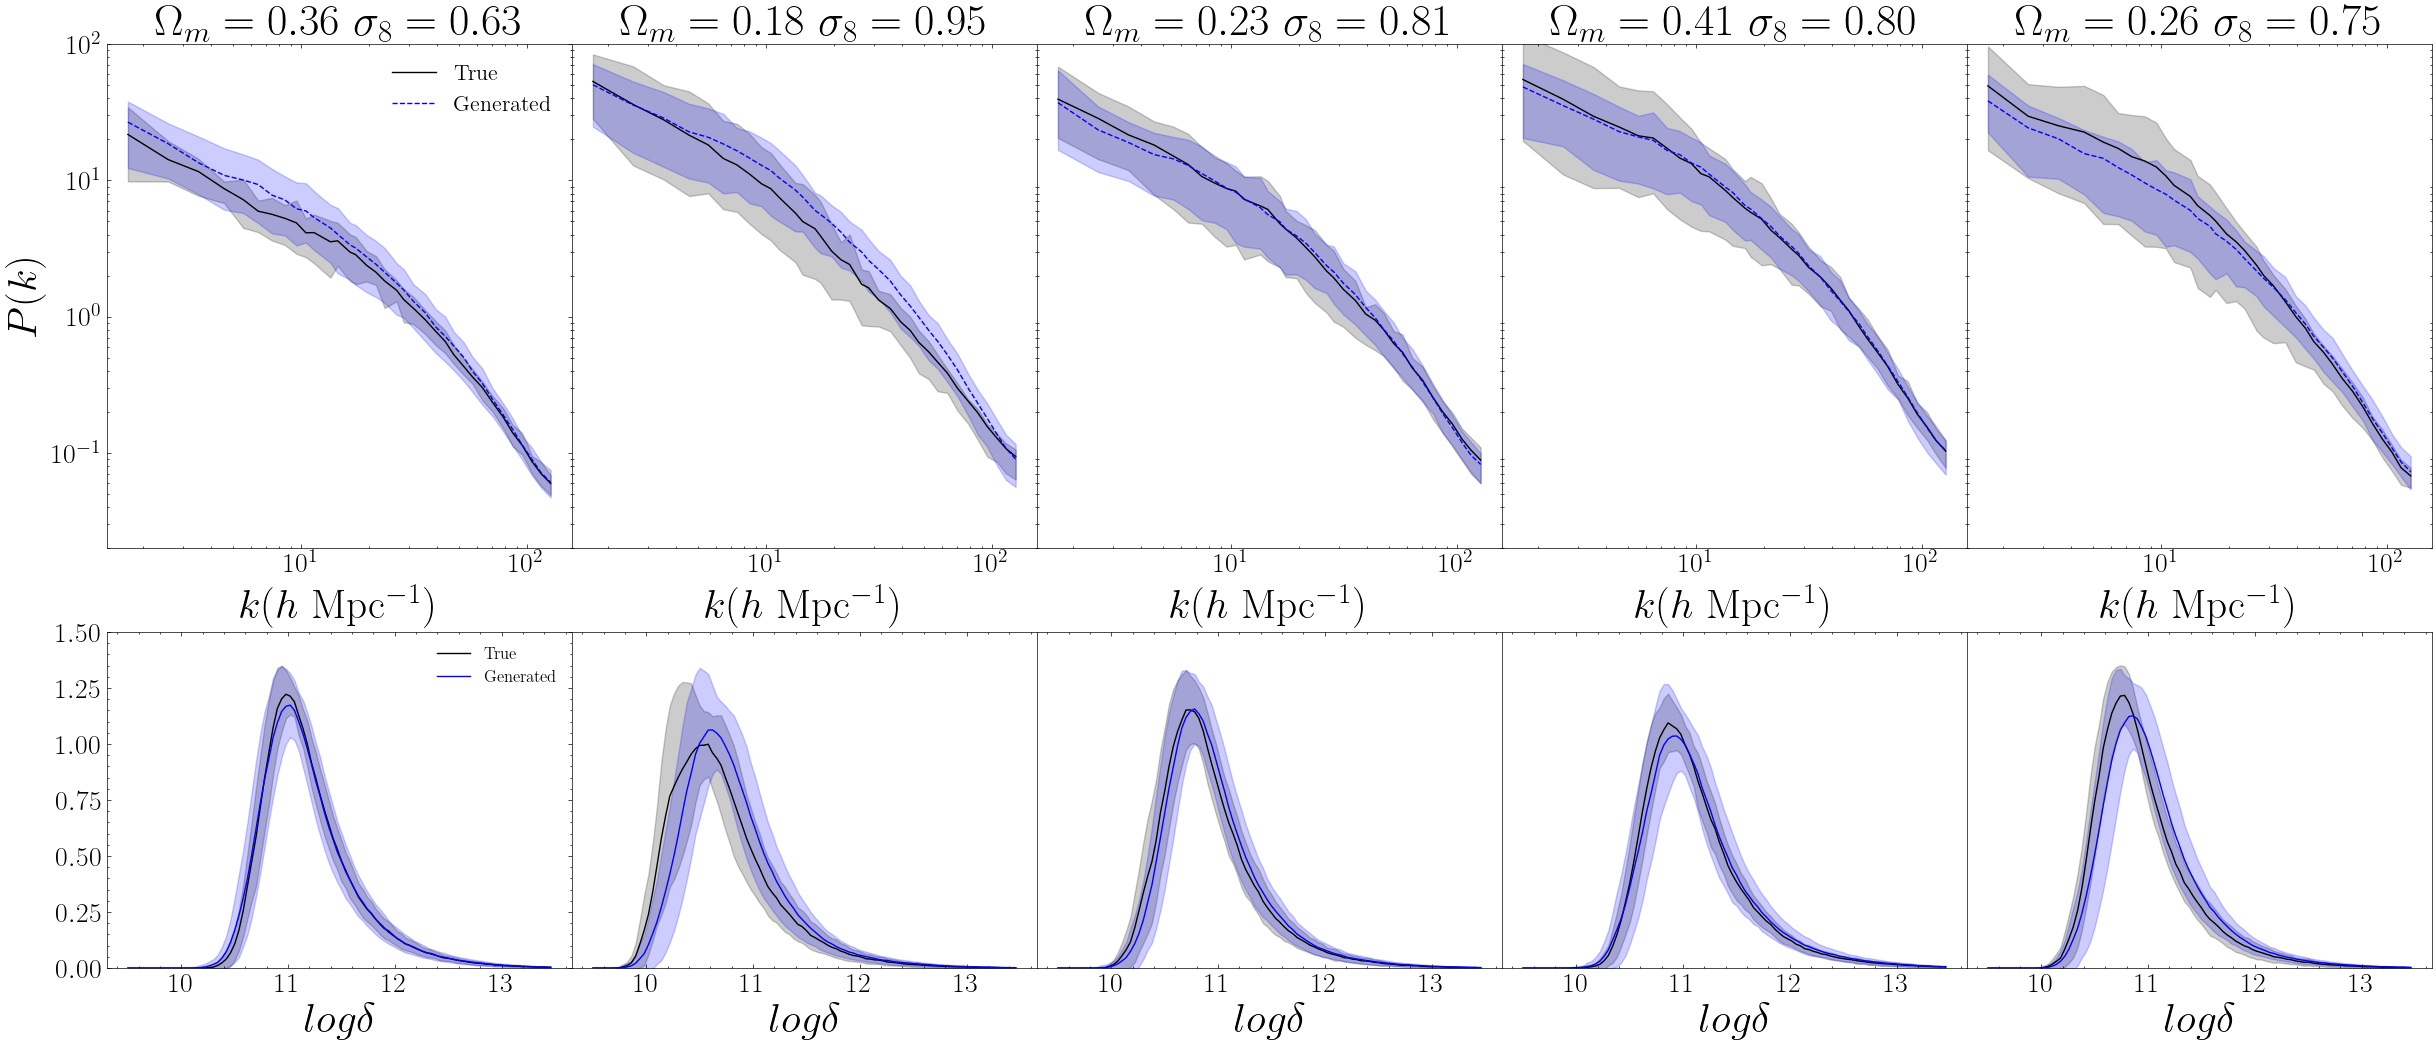

In [26]:
import matplotlib.gridspec as gridspec
cols = ['k', 'b']
which_percs = [16, 84]  # Example percentiles.
savefig_dict = {'title': 'LH'}  # Example figure title.

# Plot configurations - Adjust these flags as needed.
k2pk = False
percentiles = True
select_k = True
logscale = True
put_wavenumber_on_x = True
lnames= ['True', 'Generated']

fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2, 5, wspace=0, hspace=0.2, height_ratios=[1.5, 1])
MINVAL, MAXVAL = 3, 0
for i, samplist in enumerate(samplists):
    # for each param
    ax = fig.add_subplot(gs[i])
    ax.set_ylim([0.02, 100])
    for isd, samp in enumerate(samplist):
        # for each dbn
        assert len(samp.shape) == 2
        if k2pk:
            samp = samp * (kvals ** 2)
        meanps = np.mean(samp, axis=0)
        if percentiles:
            stdps_upp = np.percentile(samp, which_percs[1], axis=0) - meanps
            stdps_low = meanps - np.percentile(samp, which_percs[0], axis=0)
        else:
            stdps_upp = stdps_low = np.std(samp, axis=0, ddof=1)
        style = 'solid' if isd == 0 else 'dashed'
        if select_k:
            k_idx = np.unique(np.arange(len(kvals))[np.logspace(0, np.log10(len(kvals)), 50).astype(int)])
        else:
            k_idx = np.arange(len(kvals))
        ax.plot(kvals[k_idx], meanps[k_idx], c=cols[isd], label=lnames[isd], linestyle=style)
        ax.fill_between(kvals[k_idx], (meanps - stdps_low)[k_idx], (meanps + stdps_upp)[k_idx], alpha=0.2, facecolor=cols[isd], edgecolor=cols[isd])
        if np.min((meanps - stdps_low)[k_idx])<MINVAL:
            MINVAL = np.min((meanps - stdps_low)[k_idx])
        if np.max((meanps + stdps_low)[k_idx])>MAXVAL:
            MAXVAL = np.max((meanps + stdps_low)[k_idx])
    ax.set_title(names[i], fontsize=32)
    if logscale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    if put_wavenumber_on_x:
        ax.set_xlabel(r'$k (h$ Mpc$^{-1}$)', fontsize=30)
    else:
        ax.set_xlabel(r'k', fontsize=30)
    if k2pk:
        ax.set_ylabel(r'$k^2P(k)$', fontsize=30)
    elif i==0:
        ax.set_ylabel(r'$P(k)$', fontsize=30)
        ax.legend(prop={'size': 16})
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=20)

BINS = 100
Btrue = 15
Bsamp = 50

for ip in range(5):
    ax = fig.add_subplot(gs[1, ip])
    ax.set_ylim([0, 1.5])
    iptrue = np.arange(ip*Btrue, (ip+1)*Btrue)
    ipsamp = np.arange(ip*Bsamp, (ip+1)*Bsamp)
    truesub = truefields[iptrue, ...]
    gensub = sampdict['samples'][0][ipsamp, ...]
    truerange = [9.5, 13.5]
    truedbn = [np.histogram(truesub[f], bins=BINS, range=truerange, density=True) for f in range(truesub.shape[0])]
    gendbn = [np.histogram(gensub[f], bins=BINS, range=truerange, density=True) for f in range(gensub.shape[0])]
    truehist = np.vstack([t[0] for t in truedbn])

    tmeans, terrs = truehist.mean(axis=0), truehist.std(axis=0, ddof=1)
    genhist = np.vstack([v[0] for v in gendbn])
    genmeans, generrs = genhist.mean(axis=0), genhist.std(axis=0, ddof=1)
    truesub.mean(), truesub.std(ddof=1), gensub.mean(), gensub.std(ddof=1), 
    param = sampdict['params'][ipsamp[0]]
    bc = 0.5*(truedbn[0][1][1:]+truedbn[0][1][:-1])

    ax.plot(truedbn[0][1][:-1], tmeans, label='True', color='k')
    ax.plot(truedbn[0][1][:-1], genmeans, label='Generated', color='b')
    ax.fill_between(truedbn[0][1][:-1], tmeans-terrs, tmeans+terrs, color='k', alpha=0.2)
    ax.fill_between(truedbn[0][1][:-1], genmeans-generrs, genmeans+generrs, alpha=0.2, color='b')
    if ip==0:
        ax.legend(prop={'size': 12})
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    ax.set_xlabel('$log \delta$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(wspace=0)
plt.savefig('Figures/Final/LH.pdf', dpi=200)
plt.show()